In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Callable
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2. - 4*x + 5

In [ ]:
f(3.0)

20.0

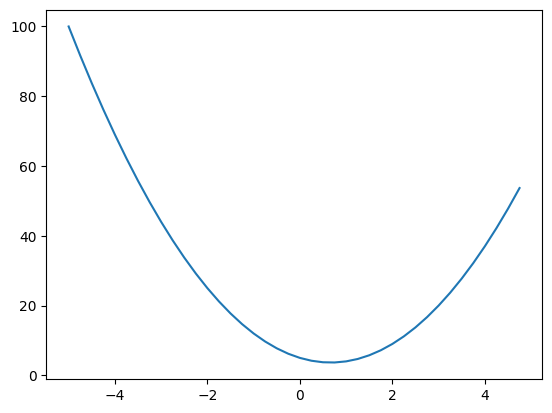

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.00000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.00001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b +c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [ ]:
class Value:

  data: float
  grad: float
  _backward: Callable[[], None]
  _prev: set['Value']
  _op: str
  label: str


  def __init__(self, data: float, _children: set['Value'] = (), _op='', label='') -> None:
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self, other: 'Value') -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other) -> 'Value':
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other) -> 'Value':
    assert isinstance(other, (int, float)), "only supports int/float"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other) -> 'Value': # other + self
    return self + other

  def __rmul__(self, other) -> 'Value': # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self) -> 'Value':
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self) -> 'Value':
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    # build list from children to root
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    # go from root to children b/c
    # children need parent for chain rule
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [ ]:
a = Value(2.0)
b = Value(4.0)
1/a


Value(data=0.5)

In [ ]:
from graphviz import Digraph

# to visualize
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

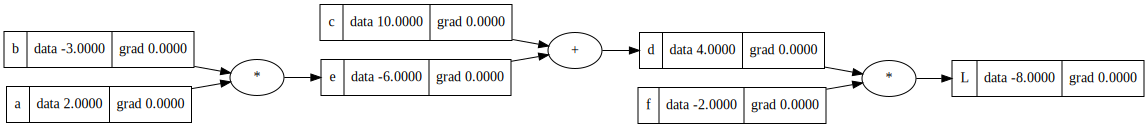

In [ ]:
draw_dot(L)

In [ ]:
# grad is with respect to L (topmost/output)

L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -2.0 * 2.0


"""
L = d * f
dL/dd = f

d = c + e
dd/dc = 1.0
dd/de = 1.0

dL/dc = dL/dd * dd/dc = f * 1.0 = f

dL/de = -2
dL/da = dL/de * de/da = e.grad * b = -2.0 * -3.0 = 6.0

"""

'\nL = d * f\ndL/dd = f\n\nd = c + e\ndd/dc = 1.0\ndd/de = 1.0\n\ndL/dc = dL/dd * dd/dc = f * 1.0 = f\n\ndL/de = -2\ndL/da = dL/de * de/da = e.grad * b = -2.0 * -3.0 = 6.0\n\n'

In [ ]:
def der():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  print((L2 - L1)/h)
der()

0.0


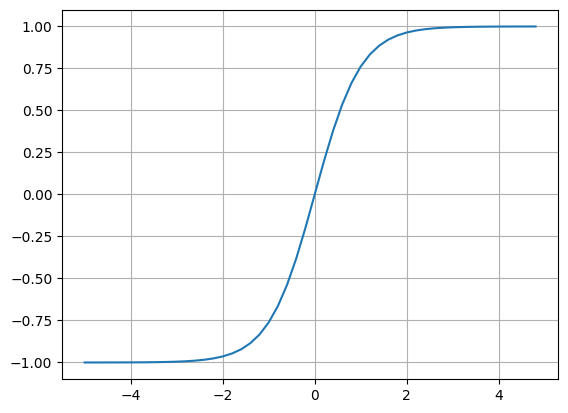

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.881375, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#output
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()

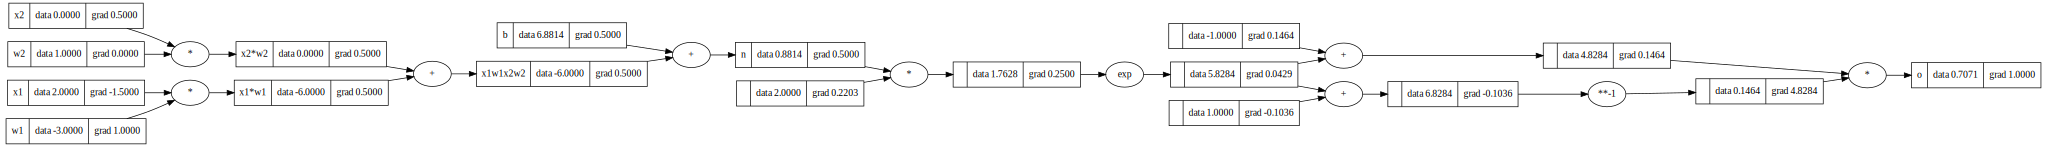

In [ ]:
draw_dot(o)

In [ ]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward() # nothing happens b/c leaf node
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [ ]:
"""o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad"""
# do/dn = 1-tanh(n)**2 = 1-o**2 = 1 - .5 = .5

'o.grad = 1.0\nn.grad = 0.5\nx1w1x2w2.grad = 0.5\nb.grad = 0.5\nx1w1.grad = 0.5\nx2w2.grad = 0.5\nx1.grad = w1.data * x1w1.grad\nw1.grad = x1.data * x1w1.grad\nw2.grad = x2.data * x2w2.grad\nx2.grad = w2.data * x2w2.grad'

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.88137]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(x2.grad.item())

0.7071050214706146
0.5000024886110417


In [ ]:
torch.Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
class Neuron:

  def __init__(self, nin) -> None:
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # weight
    self.b = Value(random.uniform(-1, 1)) # bias

  def __call__(self, x): # dot prod
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts): # inputs to neuron, number per layer
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3706902049283811)

In [ ]:
len(n.parameters())

41

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.9999999999306585),
 Value(data=-0.9999999988792384),
 Value(data=-0.9999999988906976),
 Value(data=0.9999999998735402)]

In [ ]:
## forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # subtract predictions (at first random) from ground truths
# if close, we get 0. want to minimize
# sum to get entirety so we minimze nn as a whole
# mean squared error
loss

Value(data=5.098896513379108)

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
    p.data += -0.1 * p.grad # decrease loss so go in opposite dir of grad

In [ ]:
loss

Value(data=5.098896513379108)

In [ ]:
ypred

[Value(data=-0.3706902049283811),
 Value(data=0.44580413136758623),
 Value(data=-0.24440796385970487),
 Value(data=0.2524466814104277)]

In [ ]:
n.parameters()

[Value(data=-0.16459719300945228),
 Value(data=0.7899712081420325),
 Value(data=0.40281892303262284),
 Value(data=-0.7992972623682091),
 Value(data=-0.8301091971456235),
 Value(data=0.5976780817182943),
 Value(data=-0.46481034515089403),
 Value(data=0.35680445370903335),
 Value(data=-0.9408577755635674),
 Value(data=0.6989292804113368),
 Value(data=0.30075571885578833),
 Value(data=0.13218867275528237),
 Value(data=0.7806593103868894),
 Value(data=-0.08615305103065464),
 Value(data=-0.273936040308001),
 Value(data=0.8564665257916467),
 Value(data=0.9975371387869911),
 Value(data=-0.5734513398814448),
 Value(data=0.1550120505383489),
 Value(data=0.8508654506157027),
 Value(data=0.955349915497712),
 Value(data=0.4712109687330719),
 Value(data=-0.5139351225989388),
 Value(data=0.7952249613704007),
 Value(data=-0.5095514400401792),
 Value(data=-0.5895055905025183),
 Value(data=-0.5910093951763515),
 Value(data=0.22559609634571348),
 Value(data=0.20536713621407965),
 Value(data=1.0156080611

In [ ]:
iters = 20
step_size = 0.1

for k in range(iters):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # subtract predictions (at first random) from ground truths

  for p in n.parameters(): # zero_grad so grads dont accumulate forever
    p.grad = 0.0

  # backward pass
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -step_size * p.grad

  print(k, loss.data)

0 0.0014440053124991719
1 0.001437613306271701
2 0.0014312760700591527
3 0.0014249929126172293
4 0.0014187631541882806
5 0.0014125861262649629
6 0.0014064611713597895
7 0.0014003876427801892
8 0.001394364904409117
9 0.0013883923304909606
10 0.0013824693054225855
11 0.0013765952235493322
12 0.0013707694889660668
13 0.0013649915153228372
14 0.0013592607256350954
15 0.0013535765520985895
16 0.0013479384359084063
17 0.001342345827082425
18 0.0013367981842888179
19 0.0013312949746775405


In [ ]:
ypred

[Value(data=0.9851394027456208),
 Value(data=-0.9826263693489627),
 Value(data=-0.9807436105254489),
 Value(data=0.9790761847091307)]